# Before Start
### install packages numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn by
> !pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

In [1]:
!pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ------------- -------------------------- 5.5/15.9 MB 37.2 MB/s eta 0:00:01
   -------------------------------------- - 15.5/15.9 MB 37.4 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 33.4 MB/s  0:00:00
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------  11.3/11.4 MB 58.9 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 50.7 MB/s  0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------- ----------------------------- 12.6/46.2 MB 60.7 MB/s eta 0:00:01
   ---------------------- ----------------- 25.4/46.2 MB 62.0 MB/s eta 0:00:01
   --------------------------------- ------ 38.5/46.2 MB 61.2 MB/s eta 0:00:01
   ---------------------------------------  46.1/46.2 MB 61.2 MB/s eta 0:00:01
   ---------------------------------------- 46.2/46.2 MB 54.5 MB/s  0:00:00
   -------

In [3]:
import os, sys
sys.path.append(os.path.join(*str(os.getcwd()).split('\\')[:-1]).replace(':',':\\'))
import riemannian_robust_m_estimator as rrm
import numpy as np
import pandas as pd
# 최대 열(column) 수 제한 해제
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, pickle

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

def get_sq_bias_from_mean(sample_means, manifold, mu, samplingdist):
    if samplingdist == 'gaussian':
        def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
            n = len(points)
            logs = space.metric.log(points,base)
            dists = space.metric.dist(points,base)
        
            loss = gs.sum(dists**2)/n
            if not loss_and_grad:
                return loss
            grad = -2*gs.sum(logs,axis=0)/n
            return loss, space.to_tangent(grad,base)
            
        fm = rrm.RiemannianRobustMestimator(
                    space=manifold,
                    method='default',
                    m_estimator='custom',
                    critical_value=None,
                    init_point_method='mean-projection',
                )
        fm.set_loss(squaredist)
        fm.set(init_step_size=2, max_iter=2048, epsilon=1e-6)
        fm.fit(sample_means)
        mean_of_means = fm.estimate_.x
    else:
        gm = GeometricMedian(manifold,max_iter=2048,epsilon=1e-6)
        gm.fit(sample_means)
        mean_of_means = gm.estimate_
    bias = mean_of_means - mu #['hardr_60.00']
        
    return bias.T @ bias, mean_of_means



In [ ]:
os.getcwd()

In [2]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Reload sample mean variance simulation data

In [6]:
folder = 'sphere'
res = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            res[n_samples][i] = pickle.load(f_)
        
folder = 'hyperbolic'
resh = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    resh[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            resh[n_samples][i] = pickle.load(f_)

folder = 'euclidean'
rese = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    rese[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            rese[n_samples][i] = pickle.load(f_)

# Convert dictionary rawdata to dataframe for plotting

In [7]:
#v = 'sample_mean_var'

ns = [1000]
dims = [2,5,10,20,50,100,500]
covtypes = ['full-rank','half-rank','low-rank']
samplingdists = ['gaussian','t','laplace']
res_df = pd.DataFrame()
cutoff_df = pd.DataFrame()
for d in dims:
    manifold = Hypersphere(d)
    mu = gs.array([0]*d+[1])
    for n in ns:
        for tp in covtypes:
            for sdist in samplingdists:
                for k in range(10):
                    try:
                        d1 = pd.DataFrame()
                        for v in ['sq_bias_mean','sample_mean_var','sample_var_mean','sample_var_var']:  #'sq_bias',
                            if v=='sq_bias':
                                sq_bias = {}
                                mean_of_means = {}
                                for mean_tp in res[n][k][d][sdist][tp]['mean'].keys():
                                    sample_means = res[n][k][d][sdist][tp]['mean'][mean_tp]
                                    sample_means = gs.array([mm for mm in sample_means if np.abs(mm[0]-9999)>1e-5])
                                    sq_bias[mean_tp],mean_of_means[mean_tp] = get_sq_bias_from_mean(sample_means, manifold, mu, sdist)
                                
                                d1_ = pd.DataFrame(pd.Series(sq_bias)).T
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                                
                                res[n][k][d][sdist][tp]['mean_of_means'] = mean_of_means
                            else:
                                d1_ = pd.DataFrame(res[n][k][d][sdist][tp][v])
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                        d1['n'] = n
                        d1['d'] = d
                        d1['i'] = k
                        d1['covtype'] = tp
                        d1['samplingdist'] = sdist
                        d1['trace_cov'] = np.trace(res[n][k][d][sdist][tp]['cov'])
                        eig1 = np.linalg.eigh(res[n][k][d][sdist][tp]['cov']).eigenvalues
                        d1['eff_rank'] = np.round(np.sum(eig1)/np.max(eig1),2)
                        res_df = pd.concat((res_df,d1),axis=0).reset_index(drop=True)
    
                        co1 = pd.Series(res[n][k][d][sdist][tp]['cutoff']).reset_index()
                        co1.columns= ['ptile','cutoff']
                        co1['cutoff_mean'] = [np.mean(i) for i in co1['cutoff']]
                        co1['cutoff_std'] = [np.std(i,ddof=1) for i in co1['cutoff']]
                        co1['n'] = n
                        co1['d'] = d
                        co1['i'] = k
                        co1['covtype'] = tp
                        co1['samplingdist'] = sdist
                        cutoff_df = pd.concat((cutoff_df,co1),axis=0).reset_index(drop=True)
                    except KeyError:
                        continue

mean_type = list(res[1000][0][20]['gaussian']['full-rank']['sample_mean_var'].keys())

res_df_g = res_df.groupby(['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'])[mean_type].agg(['mean','std']).reset_index()
res_df_g.columns = ['+'.join(c) if c[1]!='' else c[0] for c in res_df_g.columns]
for mtp in mean_type:
    res_df_g[f'{mtp}+ARE'] = res_df_g['fm+mean']/res_df_g[f'{mtp}+mean']

res_df_g_ = res_df_g.melt(id_vars=['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'],value_vars=res_df_g.columns[5:])
res_df_g_['mean_type'] = [i[0] for i in res_df_g_['variable'].str.split('+')]
res_df_g_['ptile'] = pd.to_numeric([i.split('_')[-1] if '_' in i else 0 for i in res_df_g_['mean_type']])
res_df_g_['mean_type'] = [i[0] for i in res_df_g_['mean_type'].str.split('_')]
res_df_g_['summary_type'] = [i[1] for i in res_df_g_['variable'].str.split('+')]
res_df_g_['ptile'] = [f'{i:0>5.2f}' for i in res_df_g_['ptile']]
print(res_df_g_.shape)
cutoff_df['ptile'] = [f'{i:0>5.2f}' for i in cutoff_df['ptile']]
res_df_g_ = res_df_g_.merge(cutoff_df,on=['n','d','i','covtype','samplingdist','ptile'],how='left')
print(res_df_g_.shape)
res_df_g_['cutoff_ratio'] = res_df_g_['cutoff_mean']/np.sqrt(res_df_g_['trace_cov'])


samplingdists = ['gaussian','t','laplace']
resh_df = pd.DataFrame()
cutoffh_df = pd.DataFrame()
for d in dims:
    manifold = Hyperboloid(d)
    mu = gs.array([1.0]+[0.0]*d)
    for n in ns:
        for tp in covtypes:
            
            for sdist in samplingdists:
                for k in range(10):
                    try:
                        d1 = pd.DataFrame()
                        for v in ['sq_bias_mean','sample_mean_var','sample_var_mean','sample_var_var']:  #'sq_bias',
                            if v=='sq_bias':
                                sq_bias = {}
                                mean_of_means = {}
                                for mean_tp in resh[n][k][d][sdist][tp]['mean'].keys():
                                    sample_means = resh[n][k][d][sdist][tp]['mean'][mean_tp]
                                    sample_means = gs.array([mm for mm in sample_means if np.abs(mm[0]-9999)>1e-5])
                                    sq_bias[mean_tp],mean_of_means[mean_tp] = get_sq_bias_from_mean(sample_means, manifold, mu, sdist)
                                
                                d1_ = pd.DataFrame(pd.Series(sq_bias)).T
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                                
                                resh[n][k][d][sdist][tp]['mean_of_means'] = mean_of_means
                            else:
                                d1_ = pd.DataFrame(resh[n][k][d][sdist][tp][v])
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                        d1['n'] = n
                        d1['d'] = d
                        d1['i'] = k
                        d1['covtype'] = tp
                        d1['samplingdist'] = sdist
                        d1['trace_cov'] = np.trace(resh[n][k][d][sdist][tp]['cov'])
                        eig1 = np.linalg.eigh(resh[n][k][d][sdist][tp]['cov']).eigenvalues
                        d1['eff_rank'] = np.round(np.sum(eig1)/np.max(eig1),2)
                        resh_df = pd.concat((resh_df,d1),axis=0).reset_index(drop=True)
    
                        co1 = pd.Series(resh[n][k][d][sdist][tp]['cutoff']).reset_index()
                        co1.columns= ['ptile','cutoff']
                        co1['cutoff_mean'] = [np.mean(i) for i in co1['cutoff']]
                        co1['cutoff_std'] = [np.std(i,ddof=1) for i in co1['cutoff']]
                        co1['n'] = n
                        co1['d'] = d
                        co1['i'] = k
                        co1['covtype'] = tp
                        co1['samplingdist'] = sdist
                        cutoffh_df = pd.concat((cutoffh_df,co1),axis=0).reset_index(drop=True)
                    except KeyError:
                        # print('error',d,tp,sdist,k)
                        continue

mean_type = list(resh[1000][0][20]['gaussian']['full-rank']['sample_mean_var'].keys())

resh_df_g = resh_df.groupby(['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'])[mean_type].agg(['mean','std']).reset_index()
resh_df_g.columns = ['+'.join(c) if c[1]!='' else c[0] for c in resh_df_g.columns]
for mtp in mean_type:
    resh_df_g[f'{mtp}+ARE'] = resh_df_g['fm+mean']/resh_df_g[f'{mtp}+mean']

resh_df_g_ = resh_df_g.melt(id_vars=['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'],value_vars=resh_df_g.columns[5:])
resh_df_g_['mean_type'] = [i[0] for i in resh_df_g_['variable'].str.split('+')]
resh_df_g_['ptile'] = pd.to_numeric([i.split('_')[-1] if '_' in i else 0 for i in resh_df_g_['mean_type']])
resh_df_g_['mean_type'] = [i[0] for i in resh_df_g_['mean_type'].str.split('_')]
resh_df_g_['summary_type'] = [i[1] for i in resh_df_g_['variable'].str.split('+')]
resh_df_g_['ptile'] = [f'{i:0>5.2f}' for i in resh_df_g_['ptile']]
print(resh_df_g_.shape)
cutoffh_df['ptile'] = [f'{i:0>5.2f}' for i in cutoffh_df['ptile']]
resh_df_g_ = resh_df_g_.merge(cutoffh_df,on=['n','d','i','covtype','samplingdist','ptile'],how='left')
print(resh_df_g_.shape)
resh_df_g_['cutoff_ratio'] = resh_df_g_['cutoff_mean']/np.sqrt(resh_df_g_['trace_cov'])

rese_df = pd.DataFrame()
cutoffh_df = pd.DataFrame()
for d in dims:
    manifold = Euclidean(d)
    mu = np.zeros(d)
    for n in ns:
        for tp in covtypes:
            
            for sdist in samplingdists:
                for k in range(10):
                    try:
                        # d1 = pd.DataFrame(rese[n][k][d][sdist][tp]['sample_mean_var'])
                        d1 = pd.DataFrame()
                        for v in ['sq_bias_mean','sample_mean_var','sample_var_mean','sample_var_var']:  #'sq_bias',
                            if v=='sq_bias':
                                sq_bias = {}
                                mean_of_means = {}
                                for mean_tp in rese[n][k][d][sdist][tp]['mean'].keys():
                                    sample_means = rese[n][k][d][sdist][tp]['mean'][mean_tp]
                                    sample_means = gs.array([mm for mm in sample_means if np.abs(mm[0]-9999)>1e-5])
                                    sq_bias[mean_tp],mean_of_means[mean_tp] = get_sq_bias_from_mean(sample_means, manifold, mu, sdist)
                                
                                d1_ = pd.DataFrame(pd.Series(sq_bias)).T
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                                
                                rese[n][k][d][sdist][tp]['mean_of_means'] = mean_of_means
                            else:
                                d1_ = pd.DataFrame(rese[n][k][d][sdist][tp][v])
                                d1_['v'] = v
                                d1 = pd.concat((d1,d1_),axis=0).reset_index(drop=True)
                        d1['n'] = n
                        d1['d'] = d
                        d1['i'] = k
                        # d1['v'] = v
                        d1['covtype'] = tp
                        d1['samplingdist'] = sdist
                        d1['trace_cov'] = np.trace(rese[n][k][d][sdist][tp]['cov'])
                        eig1 = np.linalg.eigh(rese[n][k][d][sdist][tp]['cov']).eigenvalues
                        d1['eff_rank'] = np.round(np.sum(eig1)/np.max(eig1),2)
                        rese_df = pd.concat((rese_df,d1),axis=0).reset_index(drop=True)
    
                        co1 = pd.Series(rese[n][k][d][sdist][tp]['cutoff']).reset_index()
                        co1.columns= ['ptile','cutoff']
                        co1['cutoff_mean'] = [np.mean(i) for i in co1['cutoff']]
                        co1['cutoff_std'] = [np.std(i,ddof=1) for i in co1['cutoff']]
                        co1['n'] = n
                        co1['d'] = d
                        co1['i'] = k
                        co1['covtype'] = tp
                        co1['samplingdist'] = sdist
                        cutoffh_df = pd.concat((cutoffh_df,co1),axis=0).reset_index(drop=True)
                    except KeyError:
                        # print('error',d,tp,sdist,k)
                        continue

mean_type = list(rese[1000][0][20]['gaussian']['full-rank']['sample_mean_var'].keys())

rese_df_g = rese_df.groupby(['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'])[mean_type].agg(['mean','std']).reset_index()
rese_df_g.columns = ['+'.join(c) if c[1]!='' else c[0] for c in rese_df_g.columns]
for mtp in mean_type:
    rese_df_g[f'{mtp}+ARE'] = rese_df_g['fm+mean']/rese_df_g[f'{mtp}+mean']
rese_df_g

rese_df_g_ = rese_df_g.melt(id_vars=['n','d','i','v','covtype','samplingdist','trace_cov','eff_rank'],value_vars=rese_df_g.columns[5:])
rese_df_g_['mean_type'] = [i[0] for i in rese_df_g_['variable'].str.split('+')]
rese_df_g_['ptile'] = pd.to_numeric([i.split('_')[-1] if '_' in i else 0 for i in rese_df_g_['mean_type']])
rese_df_g_['mean_type'] = [i[0] for i in rese_df_g_['mean_type'].str.split('_')]
rese_df_g_['summary_type'] = [i[1] for i in rese_df_g_['variable'].str.split('+')]
rese_df_g_['ptile'] = [f'{i:0>5.2f}' for i in rese_df_g_['ptile']]
print(rese_df_g_.shape)
cutoffh_df['ptile'] = [f'{i:0>5.2f}' for i in cutoffh_df['ptile']]
rese_df_g_ = rese_df_g_.merge(cutoffh_df,on=['n','d','i','covtype','samplingdist','ptile'],how='left')
print(rese_df_g_.shape)
rese_df_g_['cutoff_ratio'] = rese_df_g_['cutoff_mean']/np.sqrt(rese_df_g_['trace_cov'])

res_df_g_['manifold'] = 'sphere'
resh_df_g_['manifold'] = 'hyperbolic'
rese_df_g_['manifold'] = 'euclidean'
res_df_g_ = pd.concat((res_df_g_,resh_df_g_),axis=0).reset_index(drop=True)
res_df_g_ = pd.concat((res_df_g_,rese_df_g_),axis=0).reset_index(drop=True)

(468720, 13)
(468720, 16)
(407712, 13)
(407712, 16)
(468720, 13)
(468720, 16)


# Save proper data for RE vs Cutoff regression analysis

In [10]:
# (a) non-aggregation of RE trial(exist 10 cases per condition)
folder = '../2.cutoff_selection/regression_cutoff'
os.makedirs(folder,exist_ok=True)
tdf_a = {}
for mtp in ['mono','softr','hardr']:
    for sdt in ['gaussian','t','laplace']:
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['v']=='sample_mean_var') &
            (res_df_g_['n']==1000) &
            (res_df_g_['mean_type']==mtp) &
            (res_df_g_['samplingdist']==sdt)  #gaussian
            #,['d','i','covtype','ptile','variable','value']
        ].sort_values(['d','ptile','manifold','i']).reset_index(drop=True).merge(
            res_df_g_.loc[
                (res_df_g_['summary_type']=='mean') &
                (res_df_g_['mean_type']!='fm') &
                (res_df_g_['v']=='sample_mean_var') &
                (res_df_g_['n']==1000) &
                (res_df_g_['mean_type']==mtp) &
                (res_df_g_['samplingdist']==sdt)  #gaussian
                ,['d','i','covtype','samplingdist','mean_type','ptile','manifold','value']
            ],on=['d','i','covtype','samplingdist','mean_type','ptile','manifold'],how='left',suffixes=('','_v')
        ).merge(
            res_df_g_[(res_df_g_['summary_type']=='ARE') & (res_df_g_['v']=='sample_mean_var')].groupby(
                ['d','covtype','samplingdist','mean_type','ptile','manifold'])[['cutoff_mean','value']].mean().reset_index(),
            on=['d','covtype','samplingdist','mean_type','ptile','manifold'],how='left',suffixes=('','_aggf')
        )
        if sdt=='gaussian':
            tdf = tdf[(tdf['value_aggf']>=0.9)]
        tdf_a[mtp] = tdf.loc[:,['covtype','i','d','eff_rank','manifold','ptile','cutoff_ratio','value','value_v','value_aggf']].copy(deep=True).reset_index(drop=True)
        for c in ['d','eff_rank','ptile','cutoff_ratio','value','value_v','value_aggf']:
            tdf_a[mtp][c] = pd.to_numeric(tdf_a[mtp][c])
        tdf_a[mtp]['is_sphere'] = np.where(tdf_a[mtp]['manifold']=='sphere',1,0)
        tdf_a[mtp]['is_hyperbolic'] = np.where(tdf_a[mtp]['manifold']=='hyperbolic',1,0)
        tdf_a[mtp]['curvature'] = np.where(tdf_a[mtp]['manifold']=='sphere',1,
                                           np.where(tdf_a[mtp]['manifold']=='hyperbolic',-1,0))
                                           
        tdf_a[mtp]['RE'] = tdf_a[mtp]['value']
        tdf_a[mtp]['variance'] = tdf_a[mtp]['value_v']
        if sdt == 'gaussian':
            tdf_a[mtp] = tdf_a[mtp].loc[:,['i','eff_rank','is_sphere','is_hyperbolic','curvature','ptile','cutoff_ratio','d','RE','variance','value_aggf']]
            tdf_a[mtp].sort_values(['curvature','eff_rank','ptile','i','d']).to_csv(f'{folder}/regtable_{mtp}_{sdt}_rev.csv',index=False)
        else:
            tdf_a[mtp] = tdf_a[mtp].loc[:,['covtype','i','eff_rank','is_sphere','is_hyperbolic','curvature','ptile','cutoff_ratio','d','RE','variance','value_aggf']]
            tdf_a[mtp].sort_values(['curvature','covtype','eff_rank','ptile','i','d']).to_csv(f'{folder}/regtable_{mtp}_{sdt}_rev.csv',index=False)

In [50]:
# (b) aggregation of RE trial(1 case per condition by averaging)
folder = '../2.cutoff_selection/regression_cutoff_agg'
os.makedirs(folder,exist_ok=True)
tdf_a = {}
for mtp in ['mono','softr','hardr']:
    for sdt in ['gaussian','t','laplace']:
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['v']=='sample_mean_var') &
            (res_df_g_['n']==1000) &
            (res_df_g_['mean_type']==mtp) &
            (res_df_g_['samplingdist']==sdt)  #gaussian
            #,['d','i','covtype','ptile','variable','value']
        ].groupby(
            ['d','covtype','samplingdist','mean_type','eff_rank','ptile','manifold'])[['cutoff_ratio','value']].mean().reset_index()
        if sdt=='gaussian':
            tdf = tdf[(tdf['value']>=0.9)]
        tdf_a[mtp] = tdf.loc[:,['covtype','d','eff_rank','manifold','ptile','cutoff_ratio','value']].copy(deep=True).reset_index(drop=True)
        for c in ['d','eff_rank','ptile','cutoff_ratio','value']:
            tdf_a[mtp][c] = pd.to_numeric(tdf_a[mtp][c])
        tdf_a[mtp]['is_sphere'] = np.where(tdf_a[mtp]['manifold']=='sphere',1,0)
        tdf_a[mtp]['is_hyperbolic'] = np.where(tdf_a[mtp]['manifold']=='hyperbolic',1,0)
        tdf_a[mtp]['curvature'] = np.where(tdf_a[mtp]['manifold']=='sphere',1,
                                           np.where(tdf_a[mtp]['manifold']=='hyperbolic',-1,0))
                                           
        tdf_a[mtp]['RE'] = tdf_a[mtp]['value']
        
        if sdt == 'gaussian':
            tdf_a[mtp] = tdf_a[mtp].loc[:,['eff_rank','is_sphere','is_hyperbolic','curvature','ptile','cutoff_ratio','d','RE']]
            tdf_a[mtp].sort_values(['curvature','eff_rank','ptile','d']).to_csv(f'{folder}/regtable_{mtp}_{sdt}_rev.csv',index=False)
        else:
            tdf_a[mtp] = tdf_a[mtp].loc[:,['covtype','eff_rank','is_sphere','is_hyperbolic','curvature','ptile','cutoff_ratio','d','RE']]
            tdf_a[mtp].sort_values(['curvature','covtype','eff_rank','ptile','d']).to_csv(f'{folder}/regtable_{mtp}_{sdt}_rev.csv',index=False)

# (Not in paper) RE of all simulated cases in one chart(barplot) 

C:\Users\User\AppData\Local\Temp\ipykernel_42184\2518604816.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',2),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\2518604816.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',2),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\2518604816.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',2),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\2518604816.py:25: FutureWarning: 

The `errwidth` parameter 

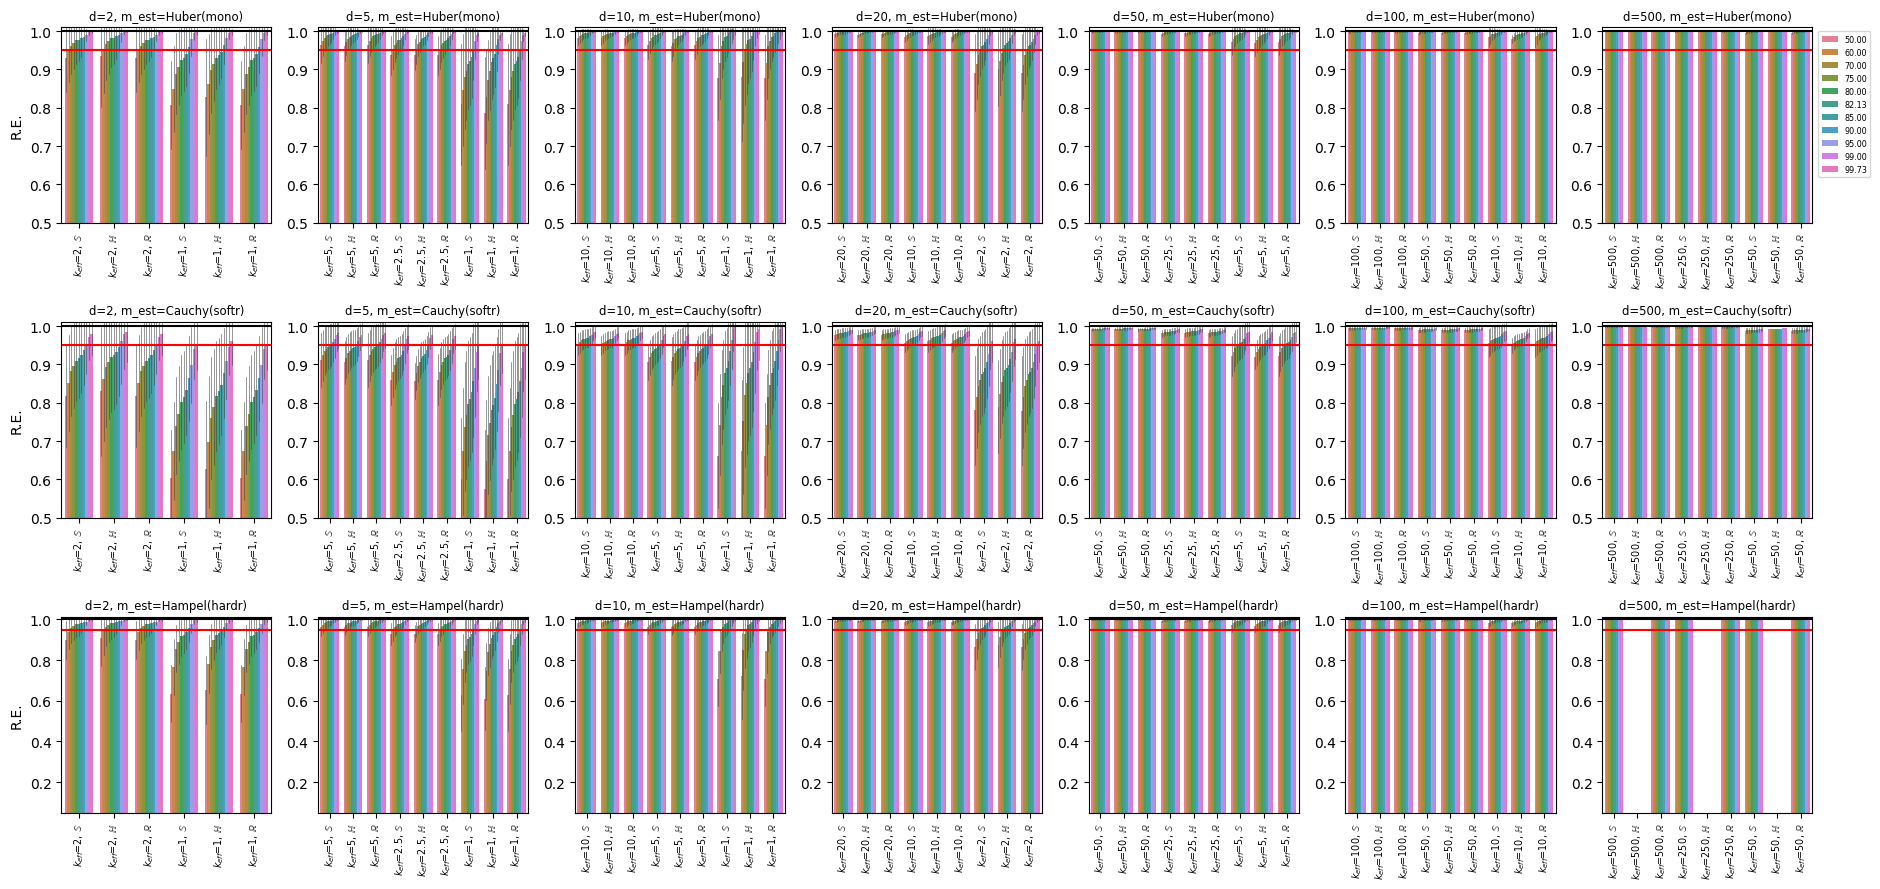

In [12]:
fig,ax = plt.subplots(3,len(dims),figsize=(2.7*len(dims),3*3))
for i,d in enumerate(dims):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']=='sample_mean_var') &
            (pd.to_numeric(res_df_g_['ptile'])>49) &
            (res_df_g_['mean_type']==m_est_type) &
            (res_df_g_['samplingdist']=='gaussian')  #gaussian
            # (res_df_g_['manifold']=='euclidean')  #gaussian
        ].copy(deep=True).sort_values(['eff_rank','manifold'],ascending=False).reset_index(drop=True)
        # tdf['ptile_'] = [f'{z}({w:.2f})' for z,w in zip(tdf['ptile'],tdf['cutoff_ratio'])]
        # print(tdf.shape)
        
        # if m_est_type=='hardr':
        #     tdf = tdf[tdf.ptile.isin(['90.00','95.00','99.00','99.73'])].reset_index(drop=True)
        tdf['R.E.'] = tdf['value']
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1).astype(str)
        tdf['eff_rank'] = tdf['eff_rank'].str.replace('.0','',regex=False)
        tdf['m1'] = np.where(tdf['manifold']=='euclidean','$\mathbb{R}$',np.where(tdf['manifold']=='sphere','$\mathbb{S}$','$\mathbb{H}$'))
        tdf['xv'] = '$k_{{eff}}$='+tdf['eff_rank']+', '+tdf['m1']
        sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',2),errwidth=0.39,)
        ax[j,i].axhline(y=0.95,c='r')
        ax[j,i].axhline(y=1,c='k')
        if m_est_type=='hardr':
            ax[j,i].set_ylim(0.05,1.01)
        else:
            ax[j,i].set_ylim(0.5,1.01)
        if (j,i)==(0,len(dims)-1):
            ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        else:
            ax[j,i].legend_.remove()
        ax[j,i].set_title(f'd={d}, m_est={m_name}({m_est_type})',fontsize='small')
        ax[j,i].tick_params(axis='x',rotation=90,labelsize='x-small')
        ax[j,i].set_xlabel('')
        if i!=0:
            ax[j,i].set_ylabel('')
# fig.suptitle('Relative Efficiency w.r.t. cutoff percentiles, effective ranks, manifolds')
plt.tight_layout()

os.makedirs('plots_for_submit',exist_ok=True)
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone.eps', bbox_inches="tight")
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone.pdf', bbox_inches="tight")

# (In paper) RE of several simulated cases(d=2,5,20,50, different eff_rank) in one chart(barplot) 

C:\Users\User\AppData\Local\Temp\ipykernel_42184\3432166948.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',1),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\3432166948.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',1),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\3432166948.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.39}` instead.

  sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',1),errwidth=0.39,)
C:\Users\User\AppData\Local\Temp\ipykernel_42184\3432166948.py:20: FutureWarning: 

The `errwidth` parameter 

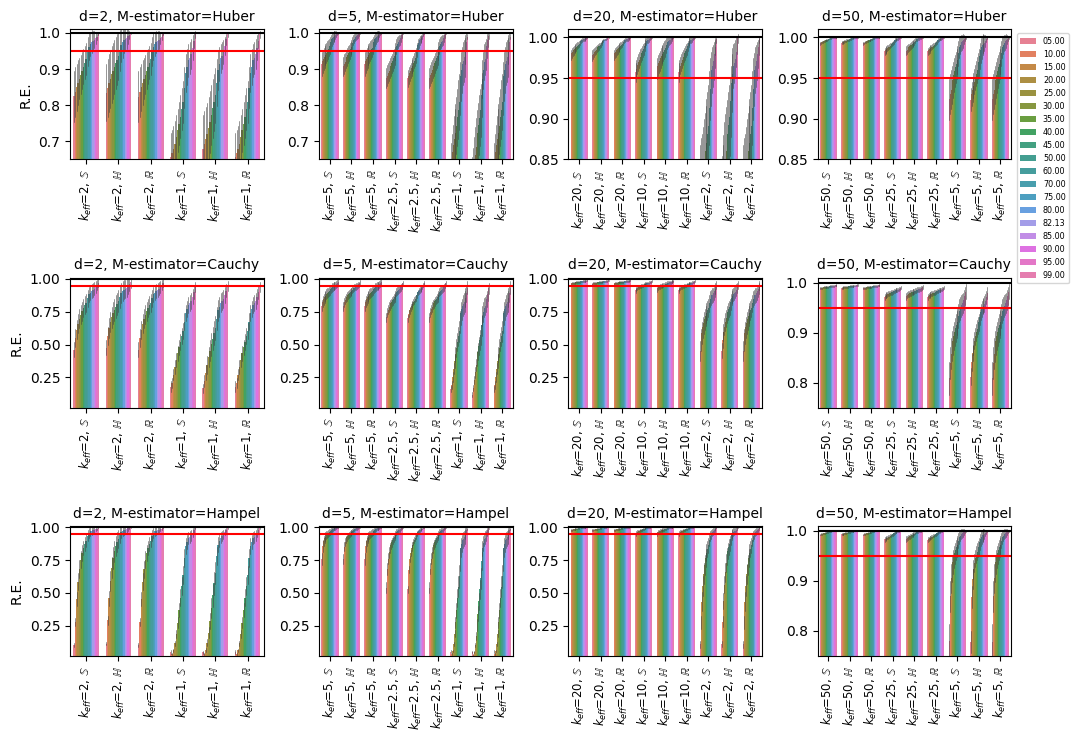

In [13]:
fig,ax = plt.subplots(3,4,figsize=(2.7*4,2.5*3))
for i,d in enumerate([2,5,20,50]):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']=='sample_mean_var') &
            (pd.to_numeric(res_df_g_['ptile'])<99.5) &
            (res_df_g_['mean_type']==m_est_type) &
            (res_df_g_['samplingdist']=='gaussian')  #gaussian
        ].copy(deep=True).sort_values(['eff_rank','manifold'],ascending=False).reset_index(drop=True)

        tdf['R.E.'] = tdf['value']
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1).astype(str)
        tdf['eff_rank'] = tdf['eff_rank'].str.replace('.0','',regex=False)
        tdf['m1'] = np.where(tdf['manifold']=='euclidean','$\mathbb{R}$',np.where(tdf['manifold']=='sphere','$\mathbb{S}$','$\mathbb{H}$'))
        tdf['xv'] = '$k_{{eff}}$='+tdf['eff_rank']+', '+tdf['m1']
        sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',1),errwidth=0.39,)
        ax[j,i].axhline(y=0.95,c='r')
        ax[j,i].axhline(y=1,c='k')
        if m_est_type=='mono':
            if i<=1:
                ax[j,i].set_ylim(0.65,1.01)
            else:
                ax[j,i].set_ylim(0.85,1.01)
        else:
            if i<3:
                ax[j,i].set_ylim(0.02,1.01)
            else:
                ax[j,i].set_ylim(0.75,1.01)
                
        if (j,i)==(0,3):
            ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        else:
            ax[j,i].legend_.remove()
        ax[j,i].set_title(f'd={d}, M-estimator={m_name}',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=90,labelsize='small')
        ax[j,i].set_xlabel('')
        if i!=0:
            ax[j,i].set_ylabel('')
# fig.suptitle('Relative Efficiency w.r.t. cutoff percentiles, effective ranks, manifolds')
plt.tight_layout()

os.makedirs('plots_for_submit',exist_ok=True)
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone_smallv.eps', bbox_inches="tight")
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone_smallv.pdf', bbox_inches="tight")

## RE vs cutoff percentile chart(d = 2,5,20,100) - Gaussian

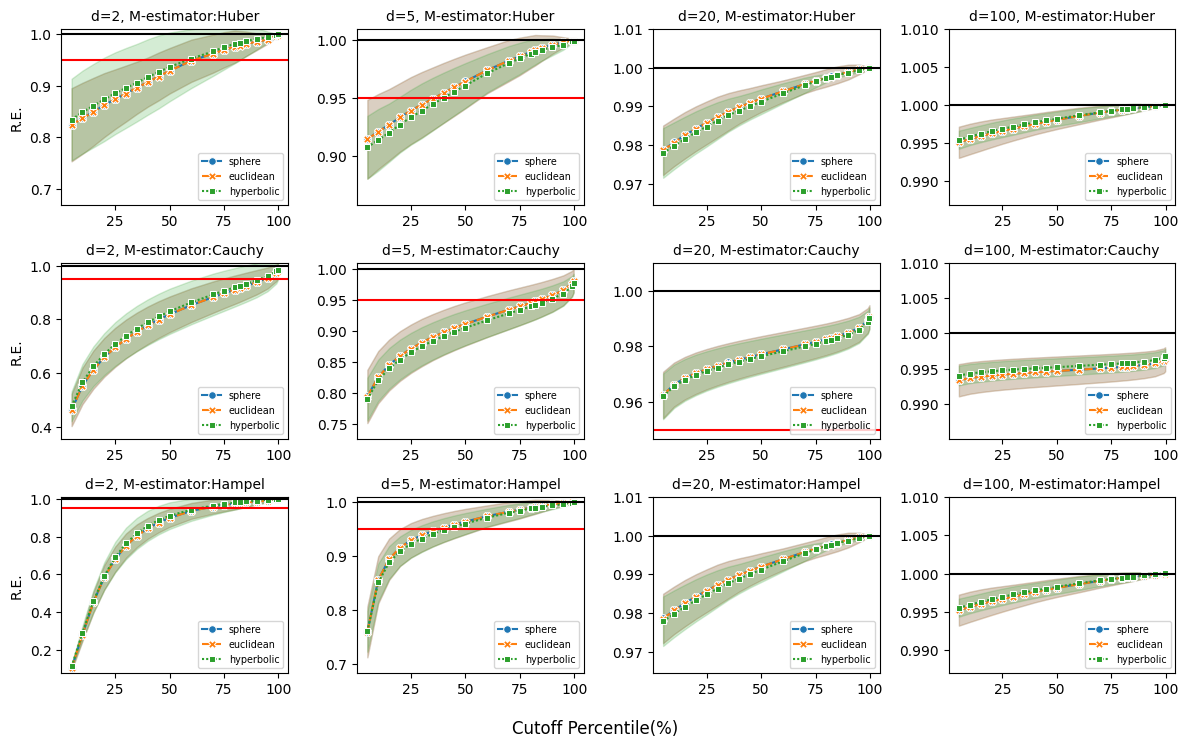

In [14]:
os.makedirs('plots_for_submit',exist_ok=True)
fig,ax = plt.subplots(3,4,figsize=(12,3*2.5))
for i,d in enumerate([2,5,20,100]): #,50,100]):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['covtype']=='full-rank') &            
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['mean_type']==m_est_type) &
                    (res_df_g_['samplingdist']=='gaussian')  #gaussian
                    # (res_df_g_['manifold']=='sphere')  
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile']) #.str.slice(0,2)
        tdf['R.E.'] = tdf['value']
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,ax=ax[j,i],errorbar=('sd',1),style=tdf.manifold,markers=True,markersize=5.5)  #
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(tdf.value.min()-0.005,1.01)
        ax[j,i].set_title(f'd={d}, M-estimator:{m_name}',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        ax[j,i].legend(fontsize='x-small',loc='lower right')
        if i!=0:
            ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        #ax[j,i].legend_.remove()
# fig.suptitle('[Relative Efficiency of M-estimators w.r.t Fréchet Mean, Manifolds (Sampled from Gaussian dist.)]')
fig.supxlabel('Cutoff Percentile(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.png')
plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.pdf')
plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.eps')

## RE vs cutoff percentile chart(d = 2,5,20,100) - heavy tail

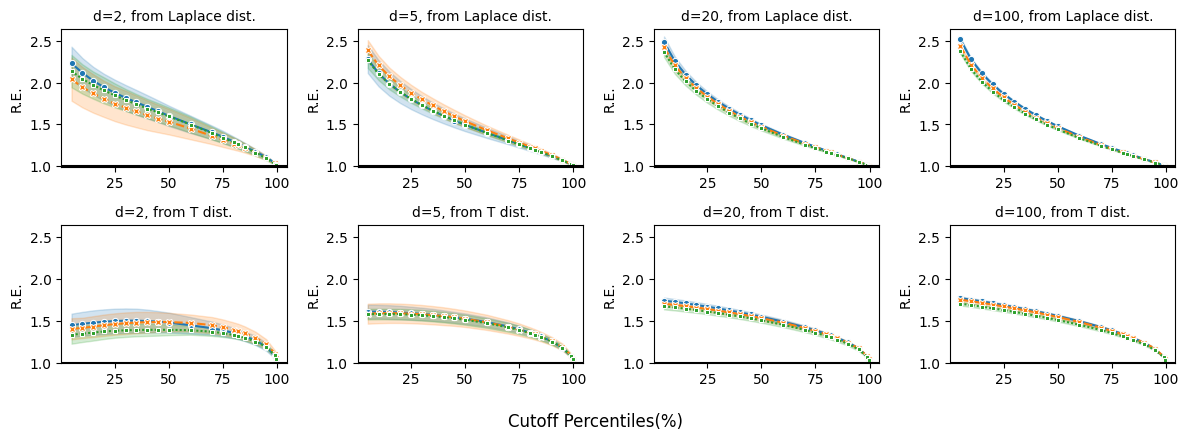

In [15]:
# (a) Huber mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['covtype']=='full-rank') &            
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['mean_type']=='mono') &
                    (res_df_g_['samplingdist']==sdist)  #gaussian
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile']) #.str.slice(0,2)
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),2.65)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.png')
plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.pdf')
plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.eps')


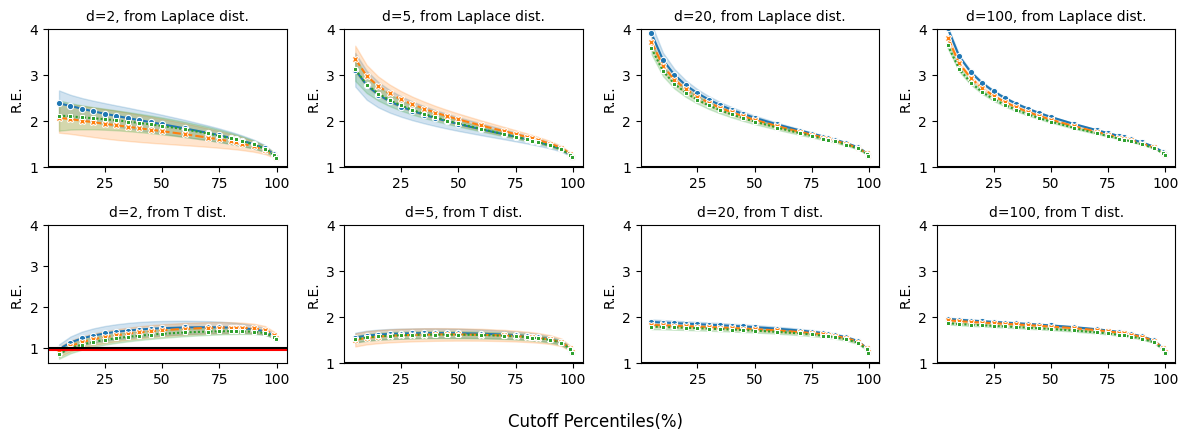

In [16]:
# (b) Cauchy mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['covtype']=='full-rank') &            
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['mean_type']=='softr') &
                    (res_df_g_['samplingdist']==sdist)  #gaussian
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile']) #.str.slice(0,2)
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),4)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.png')
plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.pdf')
plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.eps')


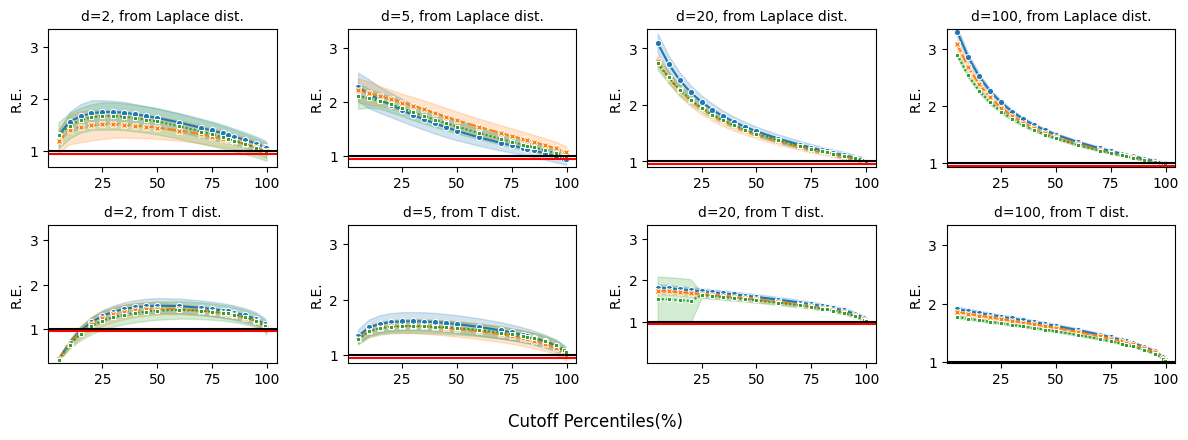

In [17]:
# (c) Hampel mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['covtype']=='full-rank') &            
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['mean_type']=='hardr') &
                    (res_df_g_['samplingdist']==sdist)  #gaussian
                    # (res_df_g_['manifold']=='sphere')  
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile']) #.str.slice(0,2)
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),3.35)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.png')
plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.pdf')
plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.eps')


# (Not in paper) check whether low-cutoff and low-dimension make M-estimator less efficient.
 > Probably, since mean point cloud of M-estimator seems larger than that of Fr\'echet mean.

(-0.07, 0.07)

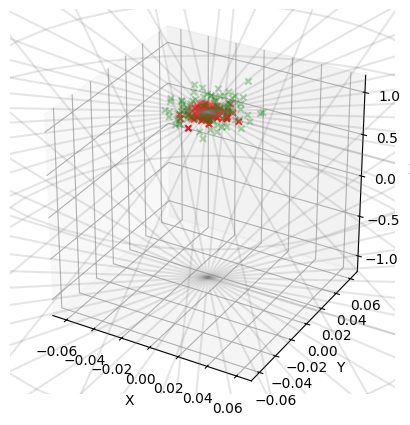

In [18]:
x = np.array(res[1000][1][2]['t']['full-rank']['mean']['hardr_5.00'])
y = np.array(res[1000][1][2]['t']['full-rank']['mean']['fm'])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
visualization.plot(x,space='S2',alpha=0.3,marker='x',c='green')
#ax.scatter(x[:,0], x[:,1], x[:,2], c='green',marker='x')
ax.scatter(y[:,0], y[:,1], y[:,2], c='red',marker='x')
plt.xlim(-0.07,0.07)
plt.ylim(-0.07,0.07)



## (Not in paper) Variance of sample mean with respect to cutoff - heavy tail
 > Seems a cutoff point minimizing the variance exists and minimizing point differs by (effective) dimension.

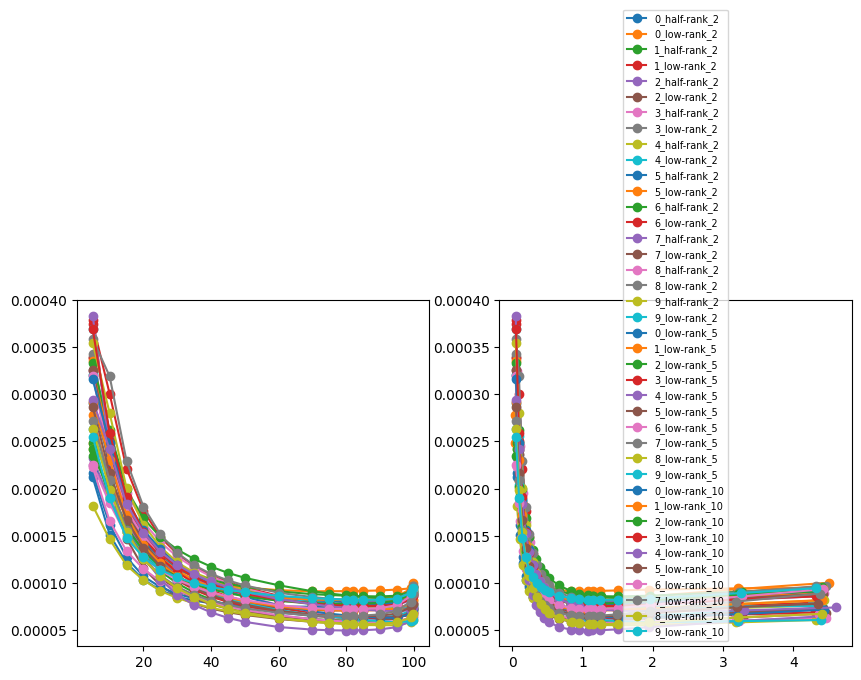

In [19]:
sdt = 't'
mtp = 'softr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['v']=='sample_mean_var') &
    #(res_df_g_['d']==2) &
    (res_df_g_['n']==1000) &
    (res_df_g_['manifold']=='sphere') &
    (np.abs(res_df_g_['eff_rank']-1)<=1e-5) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt)  #gaussian
    #,['d','i','covtype','ptile','variable','value']
].sort_values(['d','ptile','manifold','i']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='mean') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['v']=='sample_mean_var') &
        #(res_df_g_['d']==d) &
        (res_df_g_['n']==1000) &
        (res_df_g_['mean_type']==mtp) &
        # (res_df_g_['RE_target'].isin([0,95])) &
        (res_df_g_['samplingdist']==sdt)  #gaussian
        ,['d','i','covtype','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','i','covtype','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)

fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['i','covtype','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['i']==r['i']) & (a['covtype']==r['covtype']) & (a['d']==r['d'])].copy(deep=True)
    cc = '{i}_{covtype}_{d}'.format(**r)
    a1['ptile'] = pd.to_numeric(a1['ptile'])
    if r['covtype']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',label=cc)
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
plt.legend(fontsize='x-small')
    #a1 = None

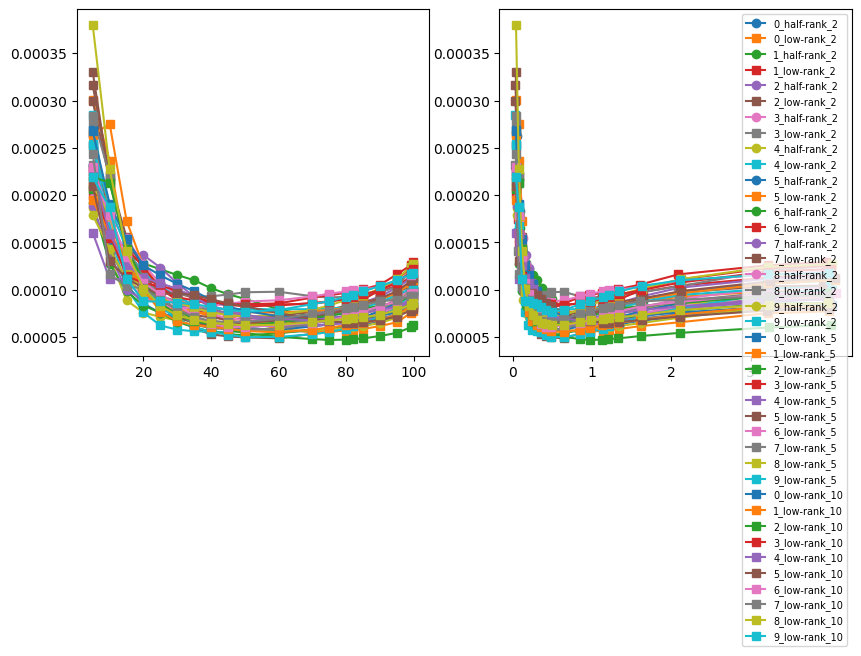

In [20]:
sdt = 'laplace'
mtp = 'hardr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['v']=='sample_mean_var') &
    (res_df_g_['n']==1000) &
    # (res_df_g_['i']>=5) &
    (res_df_g_['manifold']=='sphere') &
    #(res_df_g_['d']==10) &
    (np.abs(res_df_g_['eff_rank']-1)<=1e-5) &
    #(res_df_g_['value']>=0.9) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt)  #gaussian
    #,['d','i','covtype','ptile','variable','value']
].sort_values(['d','ptile','manifold','i']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='mean') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['v']=='sample_mean_var') &
        #(res_df_g_['d']==d) &
        (res_df_g_['n']==1000) &
        (res_df_g_['mean_type']==mtp) &
        # (res_df_g_['RE_target'].isin([0,95])) &
        (res_df_g_['samplingdist']==sdt)  #gaussian
        ,['d','i','covtype','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','i','covtype','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)

fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['i','covtype','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['i']==r['i']) & (a['covtype']==r['covtype']) & (a['d']==r['d'])].copy(deep=True)
    cc = '{i}_{covtype}_{d}'.format(**r)
    a1['ptile'] = pd.to_numeric(a1['ptile'])
    if r['covtype']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',label=cc)
    elif r['covtype']=='low-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-s',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-s',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',label=cc)
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
plt.legend(fontsize='x-small')
    #a1 = None

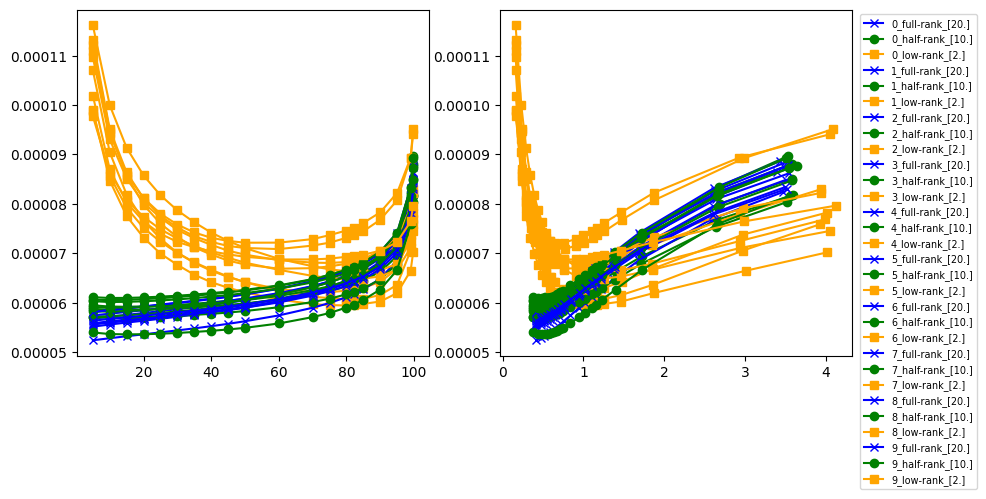

In [21]:
sdt = 't'
mtp = 'softr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['v']=='sample_mean_var') &
    (res_df_g_['n']==1000) &
    # (res_df_g_['i']>=5) &
    (res_df_g_['manifold']=='sphere') &
    (res_df_g_['d']==20) &
    #(np.abs(res_df_g_['eff_rank']-5)<=1e-5) &
    #(res_df_g_['value']>=0.9) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt)  #gaussian
    #,['d','i','covtype','ptile','variable','value']
].sort_values(['d','ptile','manifold','i']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='mean') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['v']=='sample_mean_var') &
        #(res_df_g_['d']==d) &
        (res_df_g_['n']==1000) &
        (res_df_g_['mean_type']==mtp) &
        # (res_df_g_['RE_target'].isin([0,95])) &
        (res_df_g_['samplingdist']==sdt)  #gaussian
        ,['d','i','covtype','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','i','covtype','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)

fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['i','covtype','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['i']==r['i']) & (a['covtype']==r['covtype']) & (a['d']==r['d'])].copy(deep=True)
    er = a1['eff_rank'].unique()
    cc = '{i}_{covtype}_'.format(**r) + f'{er}'
    a1['ptile'] = pd.to_numeric(a1['ptile'])
    if r['covtype']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',c='blue',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',c='blue',label=cc)
    elif r['covtype']=='low-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-s',c='orange',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-s',c='orange',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',c='green',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',c='green',label=cc)
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
ax[1].legend(fontsize='x-small',bbox_to_anchor=(1.01,1))
    #a1 = None

## (In paper) RE VS Cutoff_ratio($k_{eff}$) BY EFFECTIVE RANK 

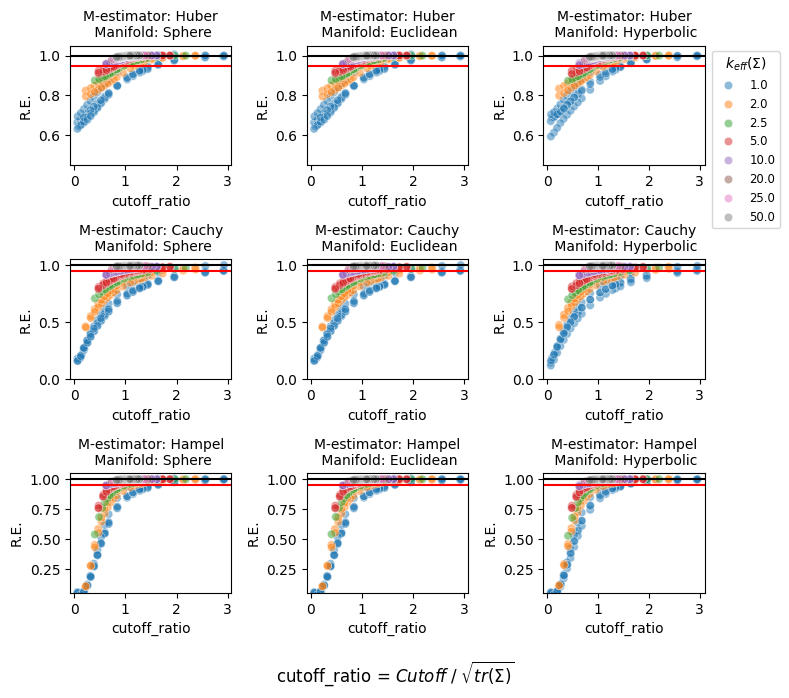

In [22]:
# (a) Gaussian
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='gaussian')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','covtype'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['eff_rank'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        if mest_type=='mono':
            ax[i,j].set_ylim(0.45,1.05)
        elif mest_type=='softr':
            ax[i,j].set_ylim(0,1.05)
        elif mest_type=='hardr':
            ax[i,j].set_ylim(0.05,1.05)
        ax[i,j].set_xticks([0,1,2,3])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_gaussian.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.png',bbox_inches='tight')

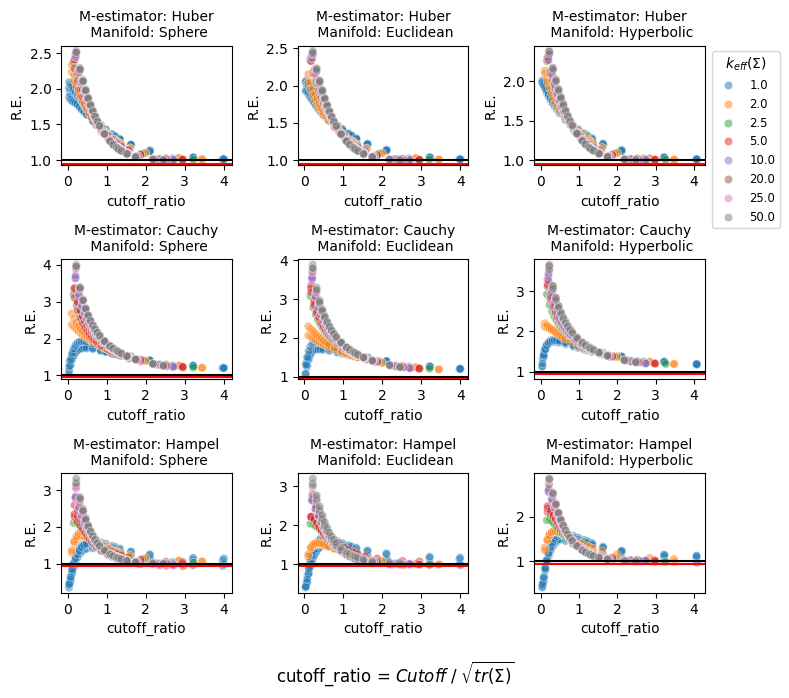

In [23]:
# (b) Laplace
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='laplace')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','covtype'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank','d']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')

        ax[i,j].set_xticks([0,1,2,3,4])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_gaussian.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.png',bbox_inches='tight')

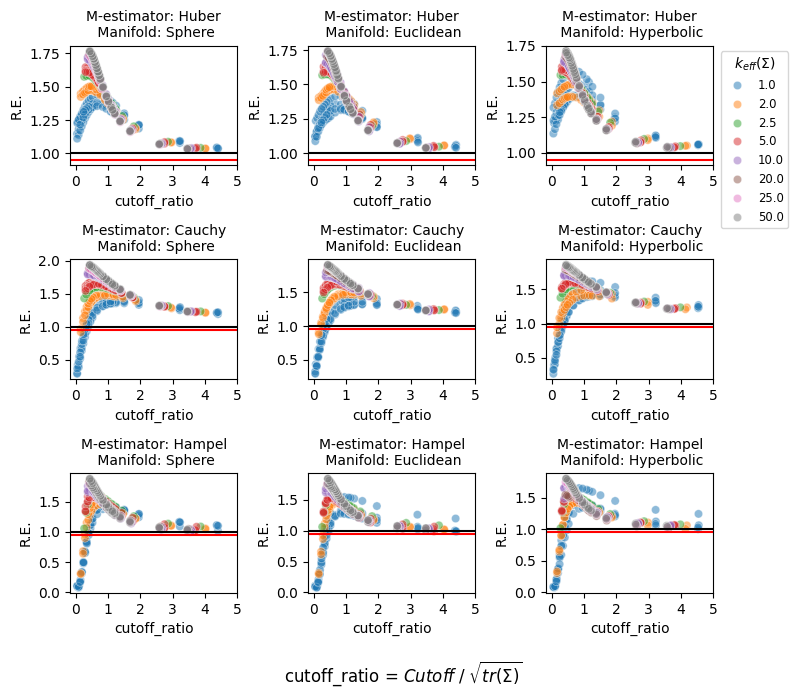

In [24]:
# (c) t
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='t')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','covtype'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['eff_rank'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        
        ax[i,j].set_xticks([0,1,2,3,4,5])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_gaussian.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.png',bbox_inches='tight')

## (In paper) Comparing chart of Gaussian/Laplace distribution on sphere for explaining RE>1 when sampled from heavy-tailed distribution.

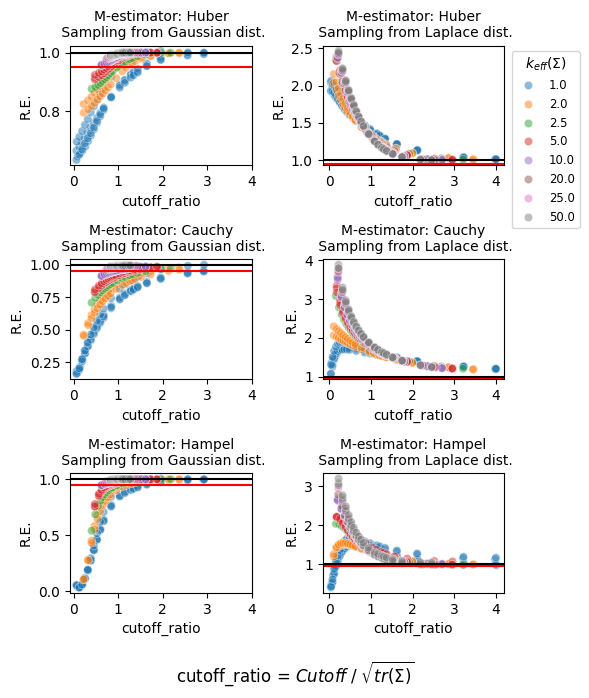

In [25]:
fig,ax = plt.subplots(3,2,figsize=(6,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['gaussian','laplace']): #,'hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']=='euclidean') &
                    (res_df_g_['samplingdist']==m)  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','covtype'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank','d']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Sampling from {m_} dist.',fontsize='medium') 
        if (i,j)!=(0,1):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')

        ax[i,j].set_xticks([0,1,2,3,4])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
#fig.subplots_adjust(wspace=0.35, hspace=0.25,bottom=0.08)


# plt.savefig('plots/RE_vs_cutoff_by_effrank_gaussian.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_euclidean.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_euclidean.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_euclidean.png',bbox_inches='tight')

# (Not in paper) Check whether d(not effective dimension) affects RE in low dimension
> Doesn't seem to have monotone relation (only effective rank matters) because when effective rank is 1, d=10 increases RE but when effective rank is 2, d=20 decreases RE.

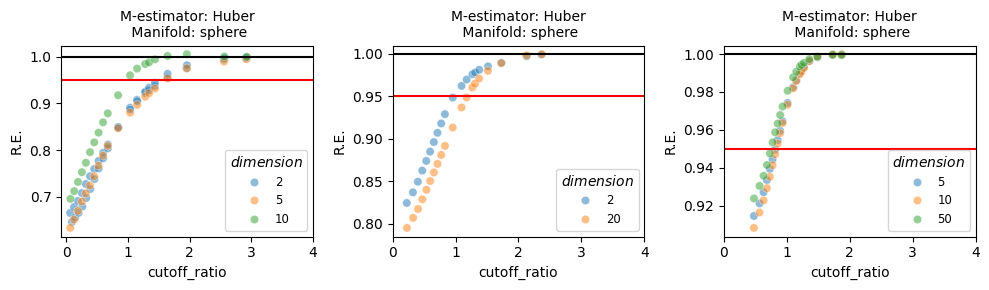

In [26]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

for i,trank in enumerate([1,2,5]):
    tdf = res_df_g_.loc[
                        (res_df_g_['summary_type']=='ARE') &
                        (res_df_g_['mean_type']!='fm') &
                        (res_df_g_['n']==1000) &
                        (res_df_g_['v']=='sample_mean_var') &
                        (np.abs(res_df_g_['eff_rank']-trank)<=1e-5) &
                        (res_df_g_['mean_type']=='mono') &
                        (res_df_g_['manifold']=='sphere') &
                        (res_df_g_['samplingdist']=='gaussian')  #gaussian
                    ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
    tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
    tdf['R.E.'] = tdf['value']
    tdf = tdf.groupby(['manifold','d','ptile','covtype'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
        ).sort_values(['eff_rank','d']).reset_index(drop=True)
    sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['d'].astype(str),alpha=0.5,ax=ax[i])
    #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
    #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
    ax[i].axhline(y=0.95,c='red')
    ax[i].axhline(y=1,c='black')
    m_ = 'sphere'
    ax[i].set_title(f'M-estimator: Huber\n Manifold: {m_}',fontsize='medium') 
    #if (i)!=(2):
    #    ax[i].legend_.remove()
    #else:
    ax[i].legend(title='$dimension$',fontsize='small')

    ax[i].set_xticks([0,1,2,3,4])
#fig.subplots_adjust(wspace=0.35, hspace=0.25,bottom=0.08)
plt.tight_layout()

## (Not in paper) d=10 and low-rank($k_{eff} = 1$), unnaturally high RE.
#### This seems due to sampling bias, I found lower RE by different seed empirically.


mono_5.00     0.689690
mono_10.00    0.704291
mono_15.00    0.721231
mono_20.00    0.738976
mono_25.00    0.757419
mono_30.00    0.776367
mono_35.00    0.794380
mono_40.00    0.811966
mono_45.00    0.830531
mono_50.00    0.848723
mono_60.00    0.887326
mono_70.00    0.925935
mono_75.00    0.941476
mono_80.00    0.953929
mono_82.13    0.958782
mono_85.00    0.966180
mono_90.00    0.977848
mono_95.00    0.988941
mono_99.00    0.997279
mono_99.73    0.998639
dtype: float64


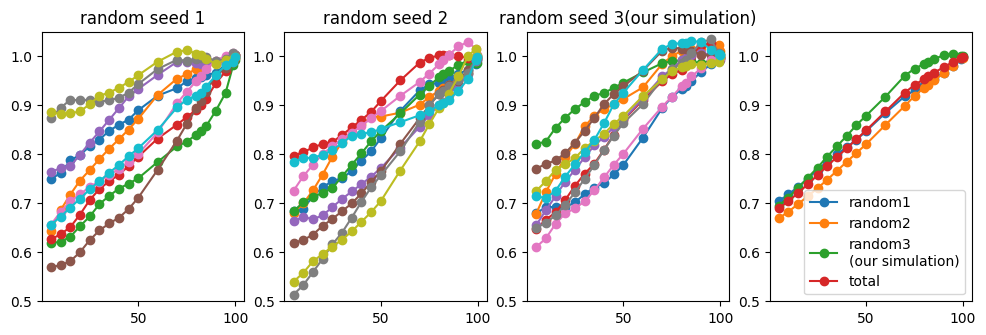

In [40]:
folder = 'old_rawdata/sphere_2_seedtest'
res_seedtest = {}
for n_samples in [1000]: #,300]: #= 25
    res_seedtest[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim10_cov4type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i] = pickle.load(f_)
            
folder = 'old_rawdata/sphere_3_seedtest'
# res = {}
for n_samples in [1000]: #,300]: #= 25
    #res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim10_cov4type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i+10] = pickle.load(f_)

folder = 'old_rawdata/sphere'
# res = {}
for n_samples in [1000]: #,300]: #= 25
    #res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim2510_cov4type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i+20] = pickle.load(f_)

RE = {}
for i in range(30):
    fm_var = res_seedtest[1000][i][10]['gaussian']['low-rank']['sample_mean_var']['fm']
    for m,v in res_seedtest[1000][i][10]['gaussian']['low-rank']['sample_mean_var'].items():
        if m[0]=='m':
            if m not in RE:
                RE[m] = []
            RE[m].append(fm_var/v[0])

RE = pd.DataFrame(RE).astype(float)
x = pd.to_numeric(RE.columns.str.slice(5,))

fig,ax = plt.subplots(1,4,figsize=(12,3.5))
for i in range(10):
    ax[0].plot(x,RE.loc[i],'o-')
ax[0].set_title('random seed 1')
for i in range(10,20):
    ax[1].plot(x,RE.loc[i],'o-')
ax[1].set_title('random seed 2')
for i in range(20,30):
    ax[2].plot(x,RE.loc[i],'o-')
ax[2].set_title('random seed 3(our simulation)')
ax[3].plot(x,RE.iloc[:10].mean(axis=0).to_numpy(),'o-',label='random1')
ax[3].plot(x,RE.iloc[10:20].mean(axis=0).to_numpy(),'o-',label='random2')
ax[3].plot(x,RE.iloc[20:30].mean(axis=0).to_numpy(),'o-',label='random3\n(our simulation)')
ax[3].plot(x,RE.mean(axis=0).to_numpy(),'o-',label='total')

ax[0].set_ylim(0.5,1.05)
ax[1].set_ylim(0.5,1.05)
ax[2].set_ylim(0.5,1.05)
ax[3].set_ylim(0.5,1.05)
ax[3].legend()
print(RE.mean(axis=0))

In [36]:
RE.iloc[:10].astype(float).mean(axis=0)

mono_5.00     0.704592
mono_10.00    0.718252
mono_15.00    0.733623
mono_20.00    0.750030
mono_25.00    0.768805
mono_30.00    0.785455
mono_35.00    0.800443
mono_40.00    0.814126
mono_45.00    0.829673
mono_50.00    0.847010
mono_60.00    0.884391
mono_70.00    0.918509
mono_75.00    0.930633
mono_80.00    0.941162
mono_82.13    0.945950
mono_85.00    0.953284
mono_90.00    0.966403
mono_95.00    0.980122
mono_99.00    0.995013
mono_99.73    0.999410
dtype: float64

## (Not in paper) Unaggregated(individual point of dimension-effective rank)

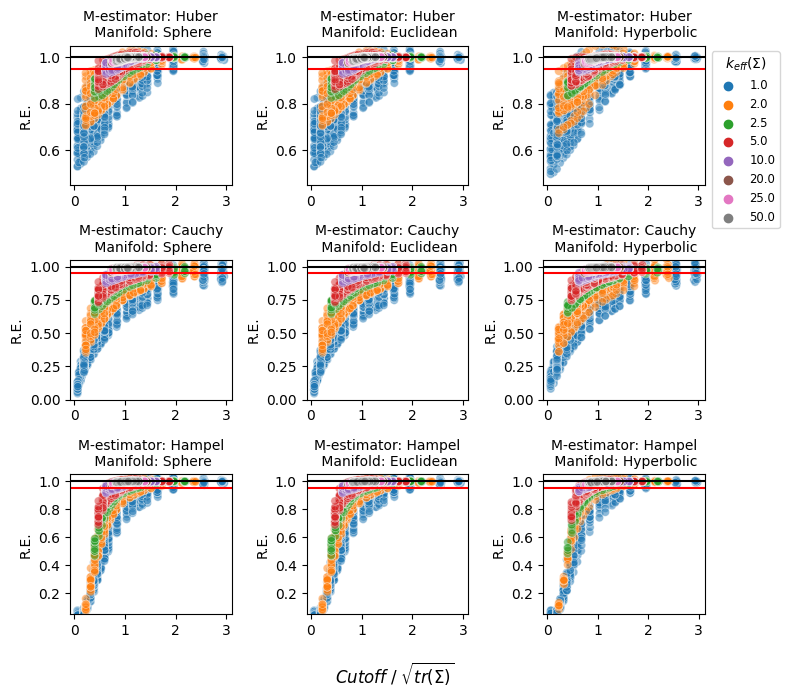

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='gaussian')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        sns.scatterplot(x=tdf['cutoff_mean']/np.sqrt(tdf['trace_cov']),y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        if mest_type=='mono':
            ax[i,j].set_ylim(0.45,1.05)
        elif mest_type=='softr':
            ax[i,j].set_ylim(0,1.05)
        elif mest_type=='hardr':
            ax[i,j].set_ylim(0.05,1.05)
        ax[i,j].set_xticks([0,1,2,3])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('$Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_gaussian.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian.png',bbox_inches='tight')

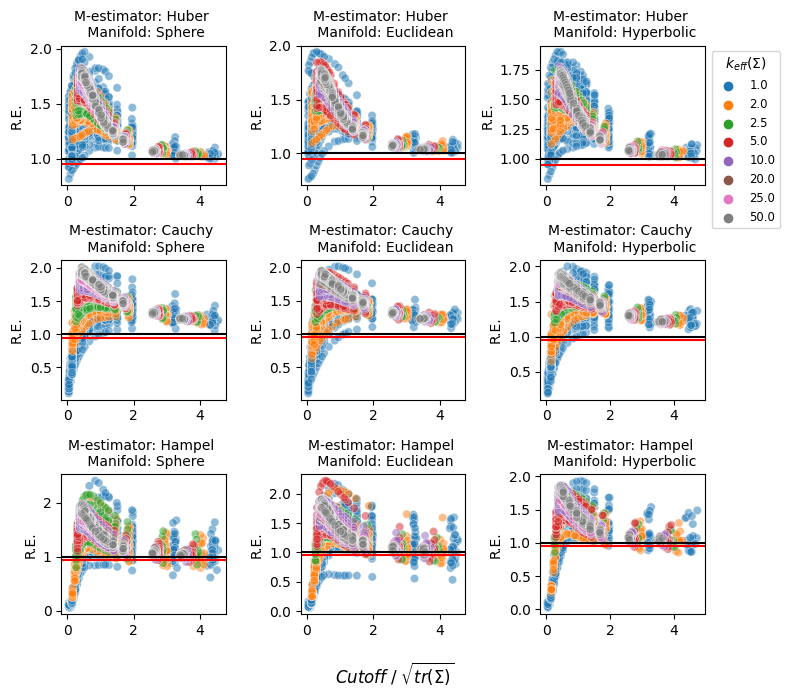

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='t')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        sns.scatterplot(x=tdf['cutoff_mean']/np.sqrt(tdf['trace_cov']),y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name} \n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        # if mest_type=='mono':
        #     ax[i,j].set_ylim(0.45,1.05)
        # elif mest_type=='softr':
        #     ax[i,j].set_ylim(0,1.05)
        # elif mest_type=='hardr':
        #     ax[i,j].set_ylim(0.05,1.05)
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from t Dist.]')
fig.supxlabel('$Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_t.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t.png',bbox_inches='tight')

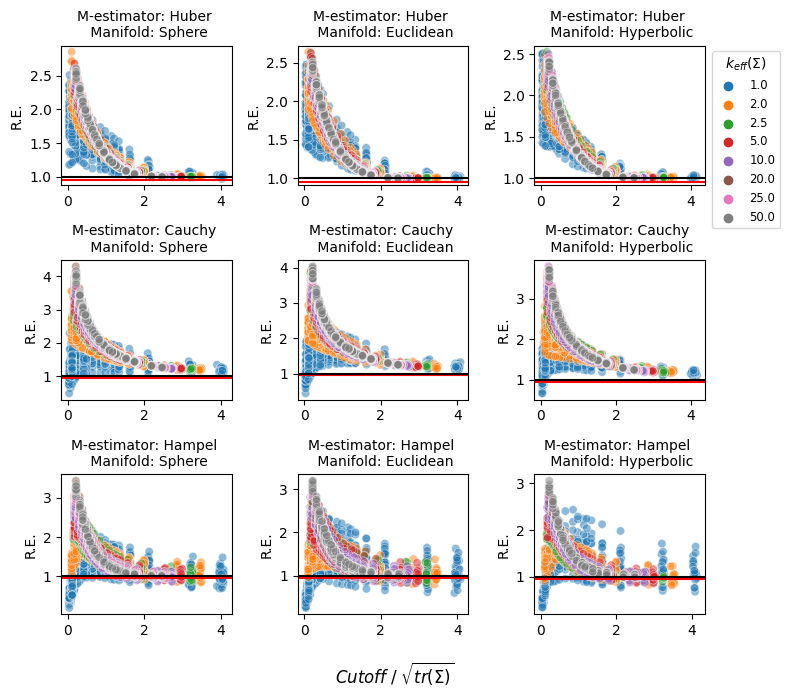

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    # (res_df_g_['d']==d) &
                    (res_df_g_['n']==1000) &
                    (res_df_g_['v']=='sample_mean_var') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='laplace')  #gaussian
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        sns.scatterplot(x=tdf['cutoff_mean']/np.sqrt(tdf['trace_cov']),y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name} \n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        # if mest_type=='mono':
        #     ax[i,j].set_ylim(0.45,1.05)
        # elif mest_type=='softr':
        #     ax[i,j].set_ylim(0,1.05)
        # elif mest_type=='hardr':
        #     ax[i,j].set_ylim(0.05,1.05)
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Laplace Dist.]')
fig.supxlabel('$Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
# plt.savefig('plots/RE_vs_cutoff_by_effrank_laplace.png')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace.png',bbox_inches='tight')

# Variance plotting

## (In paper) variance of sample mean by loss, distribution, dim = 2,10,100 with a variety of cutoff, Full rank

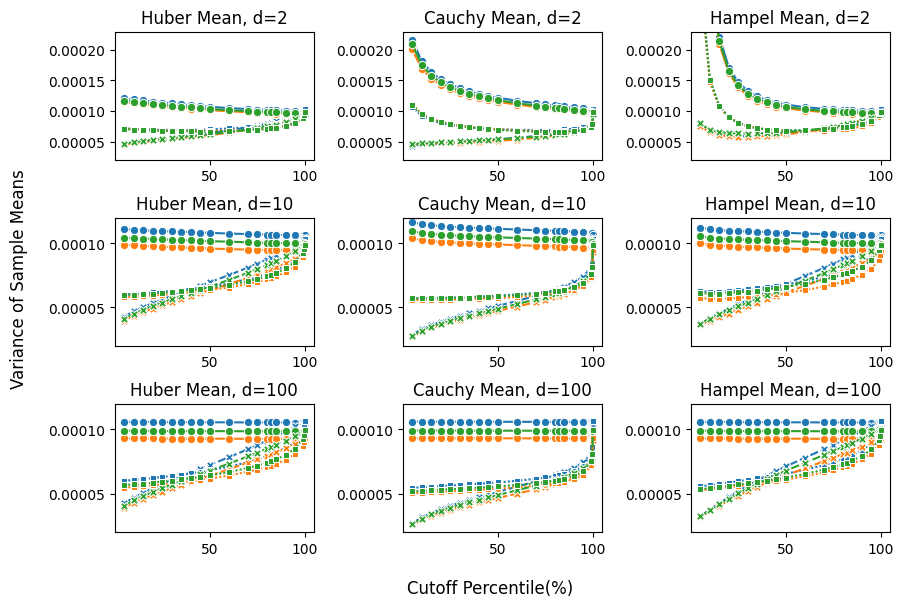

In [41]:
v = 'sample_mean_var'
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,6.5))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,d in enumerate([2,10,100]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='mean') &
            # (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']==v) &
            (res_df_g_['covtype']=='full-rank') &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)

        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        tdf = tdf.sort_values(['Cutoff Percentile','samplingdist']).reset_index(drop=True)

        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',errorbar=None,markers=True,ax=ax[i,j]) #,markersize=3.75)  #[tdf['ptile']!='00.00']  errorbar=None,
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title(f'{m_name} Mean, d={d}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        #     ax[i,j].legend_.remove()
        ax[i,j].legend_.remove()
        if i==0:
            ax[i,j].set_ylim(0.00002,0.00023)
            ax[i,j].set_yticks([0.00005,0.00010,0.00015,0.00020])
        else:
            ax[i,j].set_ylim(0.00002,0.00012)
            ax[i,j].set_yticks([0.00005,0.00010])
fig.supylabel(f'Variance of Sample Means')
fig.supxlabel(f'Cutoff Percentile(%)')
fig.subplots_adjust(wspace=0.45, hspace=0.45)
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.eps')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.png')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.pdf')
# plt.tight_layout()

In [42]:
tdf[tdf.samplingdist=='gaussian'].groupby(['samplingdist','ptile','manifold']).value.mean()  #.reset_index().iloc[:50]

samplingdist  ptile  manifold  
gaussian      00.00  euclidean     0.000098
                     hyperbolic    0.000093
                     sphere        0.000105
              05.00  euclidean     0.000099
                     hyperbolic    0.000093
                                     ...   
              99.00  hyperbolic    0.000093
                     sphere        0.000105
              99.73  euclidean     0.000098
                     hyperbolic    0.000093
                     sphere        0.000105
Name: value, Length: 63, dtype: float64

In [44]:
print('sphere variance(+a): ',105/98, 'hyperbolic variance(-a): ',93/98)

sphere variance(+a):  1.0714285714285714 hyperbolic variance(-a):  0.9489795918367347


## (Not in paper) variance of sample mean by loss, distribution, effective ranks in dim = 20 with a variety of cutoff.

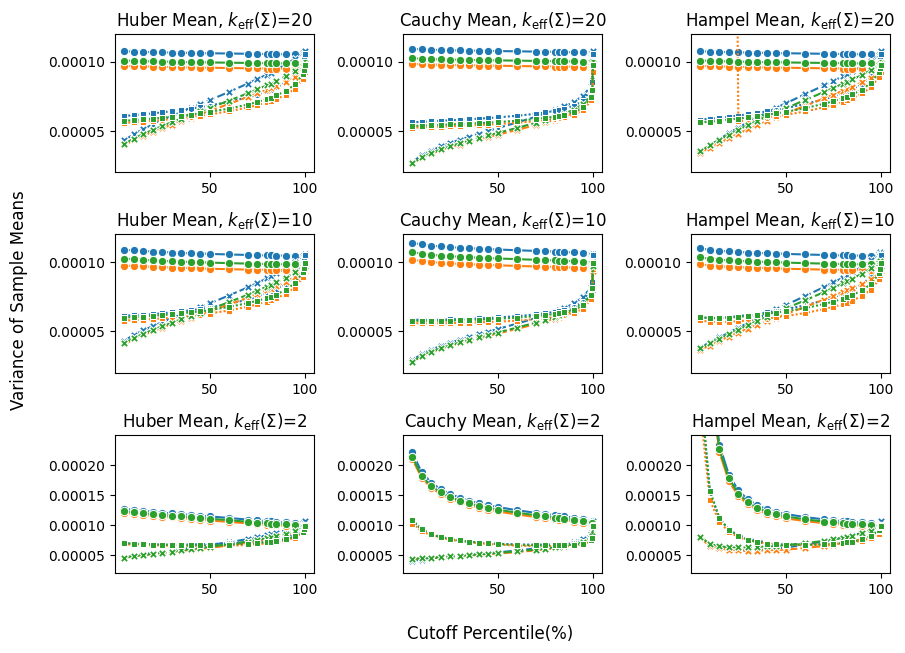

In [45]:
v = 'sample_mean_var'
d = 20
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,7))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,ct in enumerate(['full-rank','half-rank','low-rank']):
        if ct == 'full-rank':
            d_ = d
        elif ct == 'half-rank':
            d_ = d*0.5
        else:
            d_ = d*0.1
    
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='mean') &
            # (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']==v) &
            (res_df_g_['i']>0) &
            (res_df_g_['covtype']==ct) &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)

        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        tdf = tdf.sort_values(['Cutoff Percentile','samplingdist']).reset_index(drop=True)
        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',markers=True,ax=ax[i,j],errorbar=None)  #[tdf['ptile']!='00.00']
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title(f'{m_name} Mean, '+r"$k_{\mathrm{eff}}(\Sigma)$="+f'{d_:.0f}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        ax[i,j].legend_.remove()
        if i==2:
            ax[i,j].set_ylim(0.00002,0.00025)
            ax[i,j].set_yticks([0.00005,0.00010,0.00015,0.00020])
        else:
            ax[i,j].set_ylim(0.00002,0.00012)
            ax[i,j].set_yticks([0.00005,0.00010])
        # ax[i,j].set_ylim(0.00003,0.00018)
        # ax[i,j].set_yticks([0.00005,0.00010,0.00015])
fig.supylabel(f'Variance of Sample Means')
fig.supxlabel(f'Cutoff Percentile(%)')
fig.subplots_adjust(wspace=0.45, hspace=0.45)
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.eps')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.png')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.pdf')
# plt.tight_layout()

### (Not in paper) less point version of variance of means by dimension/manifold/M-estimators

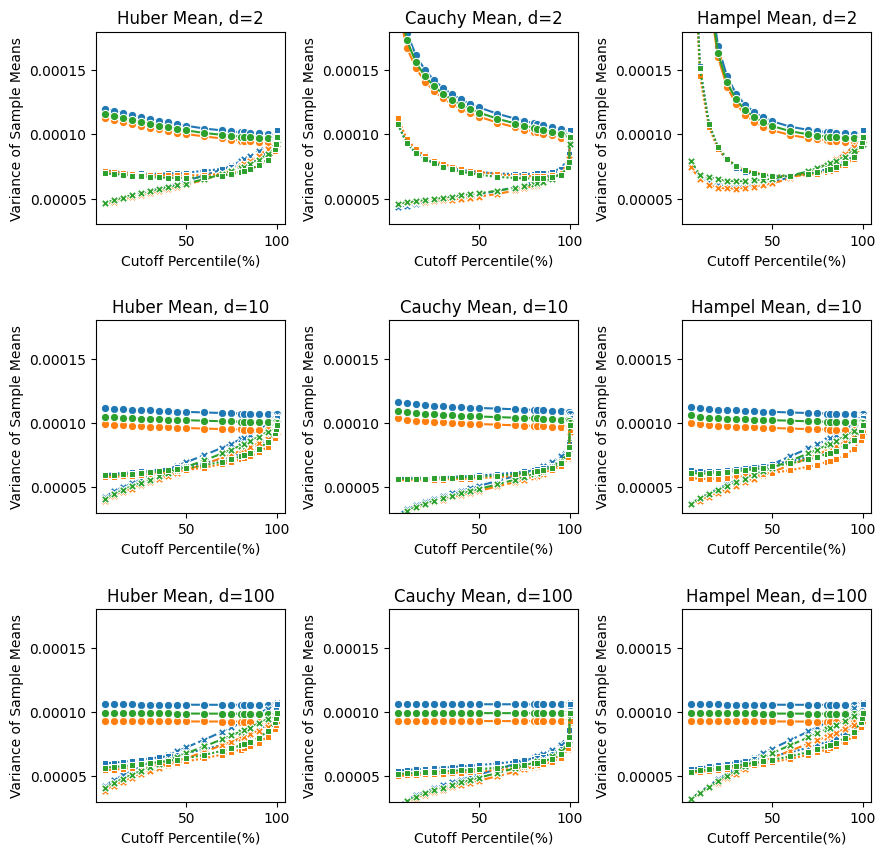

In [ ]:
v = 'sample_mean_var'
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,10))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,d in enumerate([2,10,100]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='mean') &
            # (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']==v) &
            (res_df_g_['i']>0) &
            (res_df_g_['covtype']=='full-rank') &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)
        
        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',markers=True,ax=ax[i,j],errorbar=None)  
        ax[i,j].set_ylabel(f'Variance of Sample Means')
        ax[i,j].set_xlabel(f'Cutoff Percentile(%)')
        ax[i,j].set_title(f'{m_name} Mean, d={d}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        ax[i,j].legend_.remove()
        ax[i,j].set_ylim(0.00003,0.00018)
        ax[i,j].set_yticks([0.00005,0.00010,0.00015])
fig.subplots_adjust(wspace=0.55, hspace=0.5)
# plt.tight_layout()

## (Not in paper) Sq.bias, Variance, Var/Sq.bias plotting

In [ ]:
m_est_type = 'mono'
dfs = {}
dfs[m_est_type] = {}
fig,ax = plt.subplots(4,3,figsize=(12,15))
for j,d in enumerate([2,5,10,100]):
    dfs[m_est_type][d] = {}
    for i,v in enumerate(['sq_bias','sample_mean_var']):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='mean') &
            (res_df_g_['d']==d) &
            (res_df_g_['n']==1000) &
            (res_df_g_['v']==v) &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm','gm']))) &
            (res_df_g_['samplingdist']=='gaussian')  #gaussian
        ].reset_index(drop=True).copy(deep=True)
        
        if m_est_type=='hardr':
            tdf = tdf[tdf.ptile.isin(['70.00','75.00','80.00','85.00','90.00','95.00','99.00','99.73'])].reset_index(drop=True)
        tdf['manifold'] = np.where(tdf['manifold']=='euclidean','R',np.where(tdf['manifold']=='hyperbolic','H','S'))
        tdf['xlabel'] = 'Eff.R('+pd.Series(np.round(tdf['eff_rank'],2).astype(str))+')+'+tdf['manifold']
        tdf['ptile'] = np.where(tdf['mean_type']=='fm','99.99\n(Frechet_Mean)',
                                np.where(tdf['mean_type']=='gm','00.00\n(Geo_Med)',
                                         tdf['ptile']))
                                
        tdf = tdf.sort_values(['covtype','manifold','ptile']).reset_index(drop=True)
        dfs[m_est_type][d][i] = tdf.copy()
        
        tdf[v] = tdf['value']
        sns.barplot(data=tdf,x='xlabel',y=v,hue='ptile',ax=ax[j,i],errorbar='ci',errwidth=0.35)
        # ax.axhline(y=0.95,c='r')
        # ax.axhline(y=1,c='k')
        # if m_est_type!='hardr':
        #     ax.set_ylim(0.65,1.05)
        # if i==1:
        #     ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        # else:
        ax[j,i].legend_.remove()
        ax[j,i].set_title(f'[{v}] d={d}, M_estimator:{m_est_type}',fontsize='small')
        ax[j,i].tick_params(axis='x',rotation=90)
        ax[j,i].ticklabel_format(style='plain', axis='y')
        ax[j,i].set_xlabel('')
# ax[1].set_ylim(0.00005,0.00011)
    dfs_ = dfs[m_est_type][d][0].merge(dfs[m_est_type][d][1],on=['n','d','i','covtype','eff_rank','trace_cov','samplingdist','xlabel',
                                   'variable','mean_type','ptile','summary_type','manifold'],how='left')
    dfs_['ratio'] = dfs_['value_y']/dfs_['value_x']
    sns.barplot(data=dfs_,x='xlabel',y='ratio',hue='ptile',ax=ax[j,2],errorbar='ci',errwidth=0.35)
    ax[j,2].set_title(f'[Var/Sq.Bias] d={d}, M_estimator:{m_est_type}',fontsize='small')
    ax[j,2].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
    ax[j,2].tick_params(axis='x',rotation=90)
    ax[j,2].ticklabel_format(style='plain', axis='y')
    ax[j,2].set_xlabel('')
    ax[j,2].set_yscale('log')
plt.tight_layout()
# plt.savefig('plots/sq_bias_variance_wrt_d_cutoffptiles_huber.png')